In [158]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import h5py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import scipy.constants as cs
plt.style.use('bold')
plt.style.use('presentation')

from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from shabanipy.resonators.notch_geometry import fit_complex
from shabanipy.jj.plotting_general import plot_fraunhofer
from shabanipy.plotting import jy_pink
jy_pink.register()

#: Name of the sample that must appear in the measurement name usually of the form "{Wafer}-{Piece}_{Design}-{Iteration}_{Junction}_{Cooldown}"
SAMPLE_ID = "JS626-4SQ-1-001-CD3"

#: hdf5 file number 
FILE_NUM = '034'

#: Path to store generated files
PATH = (f"/Users/bh/Desktop/Code/Topological JJ/Samples/{SAMPLE_ID}")

#: Name of generated processed data file
RAW_DATA_NAME = (f"{PATH}/Data/{SAMPLE_ID}_aggregated-data-{FILE_NUM}.hdf5")

h = h5py.File(RAW_DATA_NAME, 'r')

# temp = 'Temperature::'
ext_att = 'External Attenuation::0'
vna_pow = 'VNA Power::-20'
vg = 'RS2A::0&RS2B::0&RS3A::-6&RS3B::-6&RS4A::0&RS4B::0'
sweep = 'for-back::0'

RESULTS_PATH = f"Fits/RS3-{SAMPLE_ID}_{ext_att}_{vna_pow}_.csv"

f = h['Data'][f'{ext_att}&{vna_pow}'][f'{vg}'][f'{sweep}']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
s21 = np.array(f["S21"]).T
freq = np.array(f["Frequency"]).T
perp_field = np.array(f["Qcage - Magnet - Source current"])[:,0]

In [170]:
print(s21.shape, perp_field.shape)
print(perp_field)

(1601, 276) (276,)
[-0.0013475  -0.00134365 -0.0013398  -0.00133595 -0.0013321  -0.00132825
 -0.0013244  -0.00132055 -0.0013167  -0.00131285 -0.001309   -0.00130515
 -0.0013013  -0.00129745 -0.0012936  -0.00128975 -0.0012859  -0.00128205
 -0.0012782  -0.00127435 -0.0012705  -0.00126665 -0.0012628  -0.00125895
 -0.0012551  -0.00125125 -0.0012474  -0.00124355 -0.0012397  -0.00123585
 -0.001232   -0.00122815 -0.0012243  -0.00122045 -0.0012166  -0.00121275
 -0.0012089  -0.00120505 -0.0012012  -0.00119735 -0.0011935  -0.00118965
 -0.0011858  -0.00118195 -0.0011781  -0.00117425 -0.0011704  -0.00116655
 -0.0011627  -0.00115885 -0.001155   -0.00115115 -0.0011473  -0.00114345
 -0.0011396  -0.00113575 -0.0011319  -0.00112805 -0.0011242  -0.00112035
 -0.0011165  -0.00111265 -0.0011088  -0.00110495 -0.0011011  -0.00109725
 -0.0010934  -0.00108955 -0.0010857  -0.00108185 -0.001078   -0.00107415
 -0.0010703  -0.00106645 -0.0010626  -0.00105875 -0.0010549  -0.00105105
 -0.0010472  -0.00104335 -0.0010

<ipython-input-110-4ecfe5ba3892>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (20,10),constrained_layout=True, dpi = 50)


Text(0, 0.5, 'S21')

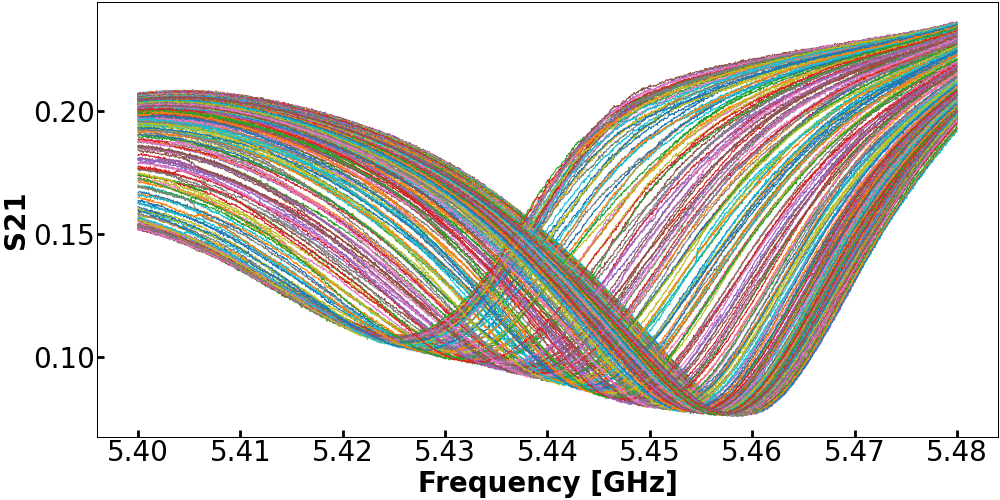

In [110]:
fig, ax = plt.subplots(figsize = (20,10),constrained_layout=True, dpi = 50)
ax.plot(freq/1e9,np.abs(s21))


ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('S21')

Text(0, 0.5, 'Freq (GHz)')

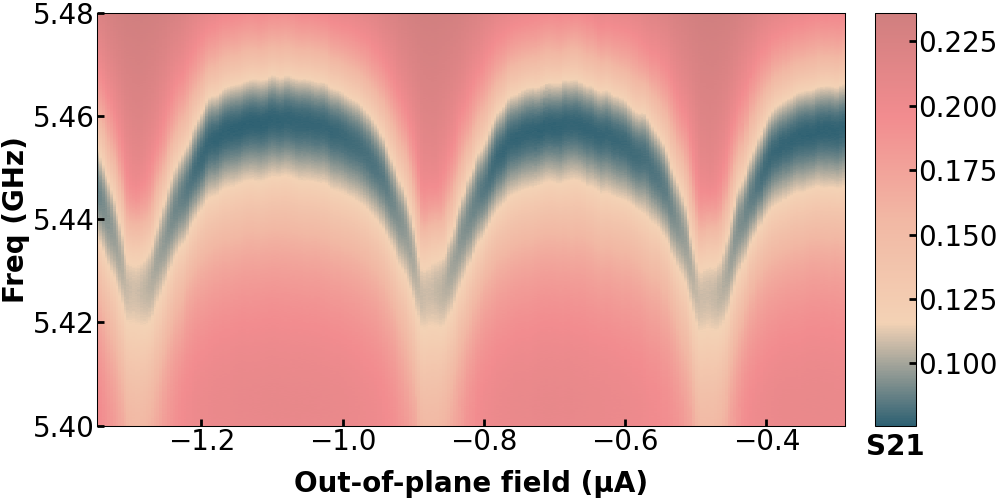

In [88]:
fig, ax = plt.subplots(figsize = (20,10),constrained_layout=True, dpi = 50)
m_ax = fig.gca()
pm = m_ax.pcolormesh(perp_field*1e3,
        freq/1e9,
        np.abs(s21),
        # vmin = cvmin if cvmin else  0,
        # vmax = cvmax if cvmax else  200,
        cmap = 'jy_pink', 
        shading = 'auto',
        linewidth=0,
        rasterized = True
        )
cb = fig.colorbar(pm, ax = m_ax,pad = 0.02)
cb.ax.set_xlabel(r'S21', labelpad = 10)
m_ax.set_xlabel('Out-of-plane field (µA)', labelpad = 20)
m_ax.set_ylabel('Freq (GHz)')

/Users/bh/Desktop/Github/shabanipy/shabanipy/resonators/resonator_tools/circuit.py:490: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ((ax2,ax0,ax1,ax3)) = plt.subplots(figsize = [15,4], nrows=1,ncols=4, constrained_layout = False, dpi = 90)
/Users/bh/Desktop/Github/shabanipy/shabanipy/resonators/notch_geometry.py:175: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(8,8))


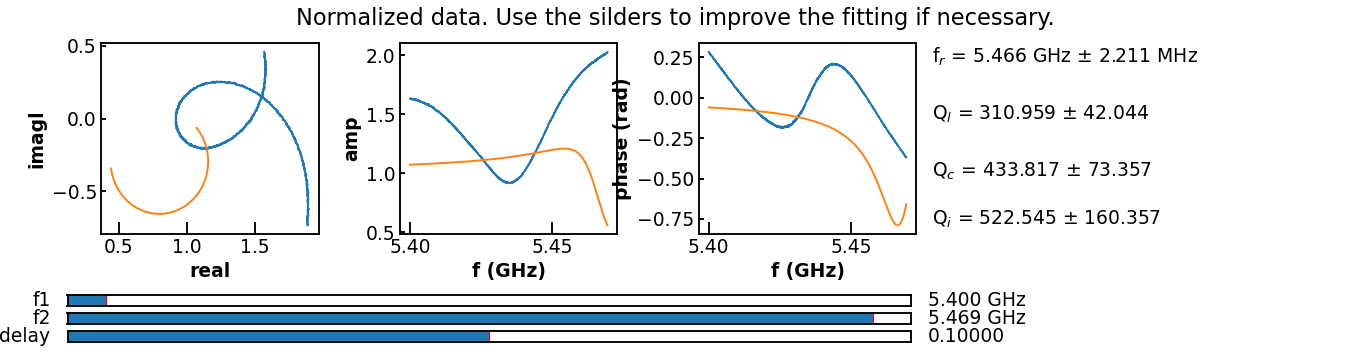

In [207]:
class LiveResult(object):
    def __init__(self):
        self.value = {}
live_result = LiveResult()

results, fdata = fit_complex(freq.T[7], s21.T[7], powers=perp_field[7],gui_fit=True, delay=.03, 
                             return_fit_data=True, delay_range=(-.1,+0.1), save_gui_fits = True,
                            save_gui_fits_path= PATH+'/Fits',
                             # save_gui_fits_filetype='.eps', 
                            live_result=live_result)

In [198]:
class LiveResult(object):
    def __init__(self):
        self.value = {}
live_result = LiveResult()

results, fdata = fit_complex(freq.T, s21.T, powers=perp_field,gui_fit=False, #delay=.098833, 
                             return_fit_data=True, delay_range=(-.1,+0.1), save_gui_fits = True,
                            save_gui_fits_path= PATH+'/Fits',
                             # save_gui_fits_filetype='.eps', 
                            live_result=live_result)

/Users/bh/opt/anaconda3/envs/yourenvname/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/bh/Desktop/Github/shabanipy/shabanipy/resonators/resonator_tools/circuit.py:373: RuntimeWarning: invalid value encountered in arcsin
  phi0 = -np.arcsin(yc/r0)
/Users/bh/Desktop/Github/shabanipy/shabanipy/resonators/resonator_tools/circlefit.py:25: RuntimeWarning: invalid value encountered in fmod
  return np.fmod(x,bound)-np.trunc(x/bound)*bound


<ipython-input-199-4d5c29b9f51d>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (20,10),constrained_layout=True, dpi = 50)


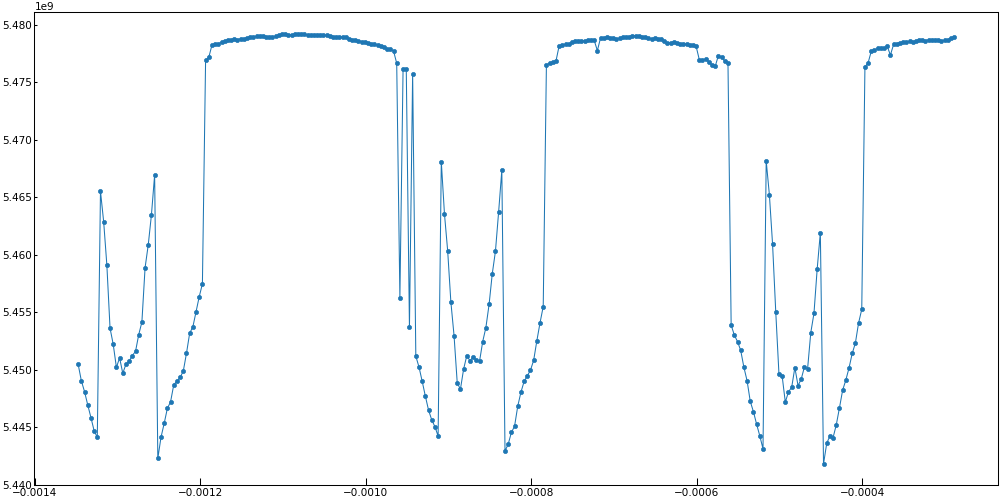

In [199]:
fig, ax = plt.subplots(figsize = (20,10),constrained_layout=True, dpi = 50)
plt.plot(perp_field, results[:,5], marker = 'o')